# Exercise 1
 <p><div class="lev1"><a href="#Task-A.-Another-LEGO-brick-in-the-wall"><span class="toc-item-num">Task A.&nbsp;&nbsp;</span>Another LEGO brick in the wall</a></div>
 <p><div class="lev1"><a href="#Task-B.-Drop-the-Bike"><span class="toc-item-num">Task B.&nbsp;&nbsp;</span>Drop the Bike</a></div>

In [1]:
%pylab inline
import pandas as pd
import re
import seaborn as sns
import matplotlib.colors as color
import datetime as date
import warnings
sns.set_context('notebook')
warnings.filterwarnings("ignore") #To ignore the FuturWarning that can come

Populating the interactive namespace from numpy and matplotlib


In [2]:
DATA_FOLDER = 'data'

## Task A. Another LEGO brick in the wall

LEGO is a popular brand of toy building bricks. They are often sold in sets in order to build a specific object. Each set contains a number of parts in different shapes, sizes and colors. This database contains information on which parts are included in different LEGO sets. It was originally compiled to help people who owned some LEGO sets already figure out what other sets they could build with the pieces they had.

This dataset contains the official LEGO colors, parts, inventories (i.e., sets of LEGO parts which assembled create an object in the LEGO world) and sets (i.e., sets of LEGO inventories which assembled create a LEGO ecosystem). The schema of the dataset can be shown in the following UML diagram: 

![lego-schema](lego-schema.png)

In this task you have to apply the following Data Wrangling pipeline:
1. Load your data into `Pandas`
* Explore it and clean its dirty parts
* Use it to answer a set of queries

Each of these subtasks are described in detail below.

### A1. Loading phase
Load all the csv files into different `DataFrames`. Use meaningful names for your `DataFrames` (e.g., the respective filenames).

*Hint: You can load files without first unzipping them (for `Pandas` version >= 0.18.1).*

In [3]:
LEGO_DATA_FOLDER = DATA_FOLDER + '/lego'

In [4]:
# id columns are set as indexes except for the dataframes Inventories_sets and Inventories_parts 
# where inventory_id is not an index but a reference to an Inventory

Inventory_sets = pd.read_csv(LEGO_DATA_FOLDER + '/inventory_sets.csv.zip', compression = 'zip')
Inventory_parts = pd.read_csv(LEGO_DATA_FOLDER + '/inventory_parts.csv.zip', compression = 'zip')
Inventories = pd.read_csv(LEGO_DATA_FOLDER + '/inventories.csv.zip', compression = 'zip', index_col = 0)
Parts = pd.read_csv(LEGO_DATA_FOLDER + '/parts.csv.zip', compression = 'zip', index_col = 0)
Colors = pd.read_csv(LEGO_DATA_FOLDER + '/colors.csv.zip', compression = 'zip', index_col = 0)
Sets = pd.read_csv(LEGO_DATA_FOLDER + '/sets.csv.zip', compression = 'zip', index_col = 0)
Themes = pd.read_csv(LEGO_DATA_FOLDER + '/themes.csv.zip', compression = 'zip', index_col = 0)
Part_categories = pd.read_csv(LEGO_DATA_FOLDER + '/part_categories.csv.zip', compression = 'zip', index_col = 0)

### A2. Cleaning phase
Explore the following columns from your dataset:

1. sets: year
* inventory_parts: quantity

What is the time range of the sets? 
What is the average quantity of the inventory parts? 
Do you see any inconsistencies? 
Provide code that detects and cleans such inconsistencies and validates the coherence of your dataset. 

In [5]:
#Cleaning of Inventory_parts.quantity

Inventory_parts.loc[Inventory_parts.quantity.isnull(), 'quantity'] = 0
print("The average of quantity (before cleaning) in inventory parts is : " + str(Inventory_parts['quantity'].mean())[:5])
Inventory_parts.loc[Inventory_parts.quantity.apply(lambda quantity: quantity == np.NINF or quantity < 0), 'quantity'] = 0
print("The average of quantity (after cleaning) in inventory parts is : " + str(Inventory_parts['quantity'].mean())[:5])

The average of quantity (before cleaning) in inventory parts is : -inf
The average of quantity (after cleaning) in inventory parts is : 2.767


In [6]:
#Cleaning of Sets.year

Sets.loc[Sets.year.isnull(), 'year'] = 0

for year_s in list(set(Sets[Sets.year.apply(lambda year: year.endswith('s'))]['year'])):
    Sets.loc[Sets.year == year_s, 'year'] = '19' + year_s[:2]
    
print("The range of year in Sets (before cleaning) is from " + str(int(Sets[['year']].min()[0])) + " to " 
      + str(int(Sets[['year']].max()[0])))
    
for year_minus in list(set(Sets[Sets.year.apply(lambda year: year.startswith('-'))]['year'])):
    Sets.loc[Sets.year == year_minus, 'year'] = year_minus[1:]
    
for year_long in list(set(Sets[Sets.year.apply(lambda year: len(year) > 4)]['year'])):
    Sets.loc[Sets.year == year_long, 'year'] = year_long[:4]
    
print("The range of year in Sets (after cleaning) is from " + str(int(Sets[['year']].min()[0])) 
      + " to " + str(int(Sets[['year']].max()[0])))

The range of year in Sets (before cleaning) is from -1962 to 20177
The range of year in Sets (after cleaning) is from 1950 to 2017


First of all, we check if there are duplicates on each file but there are none. So we remove this part of the code.

For the cleaning of the quantity of Inventory parts, some data are initialized with -inf, which is an attribute of numpy. As it is not inf and we cannot have minus object, we clean these data by assigning them a value of 0. 

About the year of Sets, the first analysis of the data give a lot of inconsistencies. For example, the data show '70s', '-1999', '19655' or '-19999'. For the years that begin with a minus, we just remove this minus. It may be due to an input error. For the year with 5 digits, we see that the 2 last digits are the same so we choose to remove the last one. About the '70s' or '80s', we ch0ose an arbitrary value corresponding to 1970 or 1980 respectively.

### A3. Querying phase
Answer the following queries using the functionality of `Pandas`:

1. List the ids of the inventories that belong to sets that contain cars. (*Hint: Find a smart way to distinguish which sets contain cars based on the sets' name*).
* Plot the distribution of part categories as a (horizontal) bar chart. Restrict yourself to the 20 largest part categories (in terms of the number of parts belonging to the category).
* Find the dominant color of each set. Then, plot using a (horizontal) bar chart, the number of sets per dominant color. Color each bar with the respective color that it represents.
* Create a scatter plot of the *luminance*\* of the sets vs their publishing year. Do you see a trend over the last years? How do you interpret it?

\*The luminance of a color is a [measure of brightness](https://en.wikipedia.org/wiki/Luminance) which, given its RGB representation, can be computed as follows:

$luminance = \sqrt{0.299*R^2 + 0.587*G^2 + 0.114*B^2}$

In [7]:
# TASK 1

# Use of a regular expression. Select whole string if there is variations around the word 'car' (plural and with capital first letter).
# Words containing car, as would 'campingcar' as well as 'scary', are excluded.
# The search is not semantic.
sets_name_idx = Sets.name.str.match('.*(^|\s)[Cc]ars?($|\s).*')
Setsaboutcars = Sets[sets_name_idx]
Inventory_setsaboutcars = pd.merge(Inventory_sets, Setsaboutcars, left_on='set_id', right_index=True)
Inventoriesaboutcars = pd.merge(Inventories, Inventory_setsaboutcars, left_index=True, right_on='inventory_id')

print("The ids of the inventories that have a set that contains a derivative of the word car")
text = ""
for index in range(size(Inventoriesaboutcars.index, 0)):
    text = text + str(Inventoriesaboutcars.index[index]) + " / "
print(text)

The ids of the inventories that have a set that contains a derivative of the word car
103 / 111 / 167 / 170 / 253 / 254 / 263 / 266 / 288 / 293 / 294 / 301 / 445 / 498 / 569 / 594 / 724 / 762 / 771 / 815 / 868 / 950 / 1036 / 1038 / 1041 / 1064 / 1074 / 1142 / 1189 / 1261 / 1260 / 1297 / 1318 / 1409 / 1410 / 1462 / 1479 / 1500 / 1584 / 1585 / 1586 / 1685 / 1847 / 1882 / 1883 / 1913 / 1932 / 2184 / 2193 / 2194 / 2195 / 2198 / 2232 / 2285 / 2287 / 2317 / 2318 / 2339 / 2346 / 2353 / 2361 / 2384 / 2429 / 2437 / 2456 / 2502 / 2519 / 2525 / 2548 / 2571 / 2632 / 2726 / 


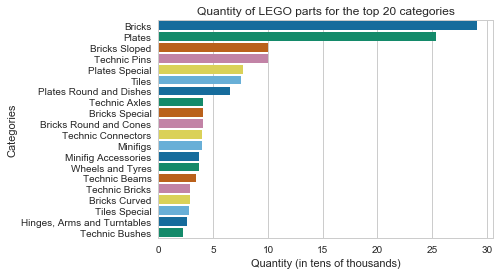

In [8]:
# TASK 2

Partswithnames = pd.merge(Parts,Part_categories, left_on='part_cat_id', right_index = True)
Partswithnames = Partswithnames.rename(columns = {'name_x':'name', 'name_y' : 'cat'})
Partsquantity = pd.merge(Inventory_parts, Partswithnames, left_on='part_id', right_index = True)
Partsquantitytop20 = Partsquantity.groupby(Partsquantity.cat).quantity.sum().sort_values(ascending=False).head(20)

sns.set_style("whitegrid")

# Use of a colorblind-friendly palette
sns.barplot(Partsquantitytop20.values/10000, Partsquantitytop20.index, palette="colorblind")
title('Quantity of LEGO parts for the top 20 categories');
ylabel('Categories');
xlabel('Quantity (in tens of thousands)');


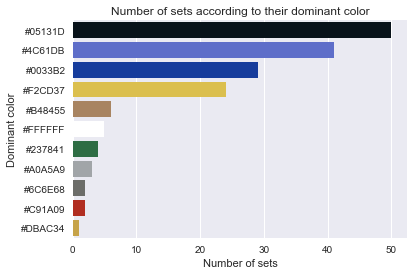

In [9]:
#TASK 3

Extended_Color_inventory_part = pd.merge(Colors, Inventory_parts, left_index =True, right_on = 'color_id')
Extended_Color_inventory_part = Extended_Color_inventory_part.drop(columns =\
                                                                ['name', 'is_trans', 'part_id', 'color_id', 'is_spare'])
Extended_Color_inventory_part = Extended_Color_inventory_part.rename(columns = {'quantity' : 'quantity_part'})

Extended_Color_Set = pd.merge(Extended_Color_inventory_part, Inventory_sets,\
                              left_on = 'inventory_id', right_on = 'inventory_id')
Extended_Color_Set = Extended_Color_Set.drop(columns = ['inventory_id'])

Extended_Color_Set = Extended_Color_Set.drop( index =\
                    Extended_Color_Set.loc[Extended_Color_Set.quantity_part == 0.0, 'quantity_part'].index)
Extended_Color_Set = Extended_Color_Set.groupby([Extended_Color_Set.set_id, Extended_Color_Set.rgb]).sum()\
                    .sort_values(by = 'quantity_part', ascending = False)
Extended_Color_Set['quantity_dominant'] = Extended_Color_Set.quantity_part * Extended_Color_Set.quantity
Extended_Color_Set = Extended_Color_Set.drop(columns = ['quantity_part', 'quantity'])
Extended_Color_Set = Extended_Color_Set.unstack().fillna(0)

set_ids, colors = [], []

for index_num in range(size(Extended_Color_Set, 0)):
    Serie = Extended_Color_Set.iloc[index_num].sort_values(ascending = False).nlargest(1, 'first')
    set_ids.append(Serie.name)
    colors.append('#' + Serie.index[0][1])
    
Set_and_dominant_colors = pd.DataFrame({"major_color" : colors, "set_id" : set_ids})
Set_id_with_dominant_colors = Set_and_dominant_colors.copy() #This step is for the task number 4
Set_and_dominant_colors = Set_and_dominant_colors.groupby(Set_and_dominant_colors.major_color).count()\
                            .sort_values(by = 'set_id', ascending=False)

sns.set_style("darkgrid")
sns.barplot(Set_and_dominant_colors['set_id'].values, Set_and_dominant_colors['set_id'].index, \
            palette = Set_and_dominant_colors['set_id'].index)
title("Number of sets according to their dominant color");
xlabel("Number of sets");
ylabel("Dominant color");

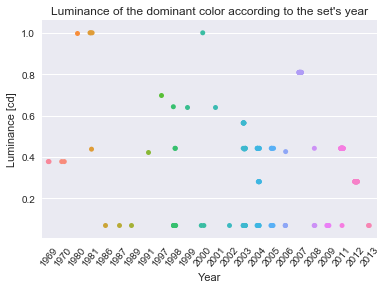

In [10]:
#TASK 4

Year_of_set_with_dominant_colors = pd.merge(Sets, Set_id_with_dominant_colors, left_index = True, right_on = 'set_id')
Year_of_set_with_dominant_colors = Year_of_set_with_dominant_colors\
                                    .drop(columns = ['name', 'theme_id', 'num_parts', 'set_id'])
luminance, index_num = [], 0

for index_num in range(size(Year_of_set_with_dominant_colors,0)):
    R, G, B = color.hex2color(Year_of_set_with_dominant_colors['major_color'][index_num])
    luminance.append(sqrt(0.299 * R**2 + 0.587 * G**2 + 0.114 * B**2))

Year_of_set_with_luminance = pd.DataFrame({'year' : Year_of_set_with_dominant_colors.year.values,\
                                          'luminance' : luminance}).sort_values(by = 'year')


sns.set_style("darkgrid")

# Use of the jitter option to get an idea of points superposition
plot = sns.stripplot(Year_of_set_with_luminance.year, Year_of_set_with_luminance.luminance,\
                     data =Year_of_set_with_luminance, jitter = True)
plot.set(xlabel='Year',ylabel='Luminance [cd]')
plot.set_xticklabels(plot.get_xticklabels(),rotation = 50);
title("Luminance of the dominant color according to the set's year");


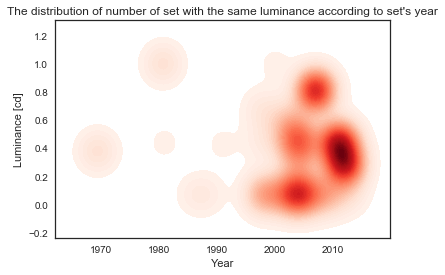

In [11]:
# TASK 4

# Interesting plot to visualize data distribution
sns.set_style('white')

# 'Reds' colormap is colorblind friendly and makes sense even in grayscale
sns.kdeplot(Year_of_set_with_luminance.year, Year_of_set_with_luminance.luminance,\
            shade=True, cmap="Reds", shade_lowest=False,  n_levels=50);
xlabel("Year");
ylabel("Luminance [cd]");
title("The distribution of number of set with the same luminance according to set's year");

#### Task 1 :
We use a RegularExpression to select Sets whose names contain a variation of the word 'car'.
The chosen RegEx is the following : '.*(^|\s)[Cc]ars?($|\s).*' 
It will select strings in which there is the word car, both singular and plural and with capital first letter or not.
It must be a delimited word. The search is not semantic but purely typographic.
We then merge the selected Sets with Inventory_sets and then with Inventories. Finally, we display the indexes of the selected inventories.

#### Task 2:



## Task B. Drop the bike

*Los Angeles Metro* has been sharing publicly [anonymized *Metro Bike Share* trip data](https://bikeshare.metro.net/about/data/) under the [Open Database License (ODbL)](http://opendatacommons.org/licenses/odbl/1.0/).

In this task you will again perform data wrangling and interpretation.

### B1. Loading phase
Load the json file into a `DataFrame`.


In [12]:
BIKES_DATA_FOLDER = DATA_FOLDER + '/bikes'

In [13]:
Metro_bike_share = pd.read_json(BIKES_DATA_FOLDER + '/metro-bike-share-trip-data.json.zip', compression = 'zip')
Metro_bike_share.head(5) # Permet d'afficher les 5 premières colonnes pour mieux se représenter les data

,Bike ID,Duration,End Time,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Passholder Type,Plan Duration,Start Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Trip ID,Trip Route Category
0,6281.0,180,2016-07-07T04:20:00,3014.0,34.056610,-118.23721,Monthly Pass,30.0,2016-07-07T04:17:00,3014.0,34.056610,-118.23721,1912818,Round Trip
1,6281.0,1980,2016-07-07T06:33:00,3014.0,34.056610,-118.23721,Monthly Pass,30.0,2016-07-07T06:00:00,3014.0,34.056610,-118.23721,1919661,Round Trip
2,5861.0,300,2016-07-07T10:37:00,3016.0,34.052898,-118.24156,Flex Pass,365.0,2016-07-07T10:32:00,3016.0,34.052898,-118.24156,1933383,Round Trip
3,5861.0,10860,2016-07-07T13:38:00,3016.0,34.052898,-118.24156,Flex Pass,365.0,2016-07-07T10:37:00,3016.0,34.052898,-118.24156,1944197,Round Trip
4,6674.0,420,2016-07-07T12:58:00,3032.0,34.049889,-118.25588,Walk-up,0.0,2016-07-07T12:51:00,3032.0,34.049889,-118.25588,1940317,Round Trip


### B2. Cleaning phase
Describe the type and the value range of each attribute. Indicate and transform the attributes that are `Categorical`. Are there redundant columns in the dataset (i.e., are there columns whose value depends only on the value of another column)? What are the possible pitfalls of having such columns? Reduce *data redundancy* by extracting such columns to separate `DataFrames`. Which of the two formats (the initial one or the one with reduced data redundancy) is more susceptible to inconsistencies? At the end print for each `Dataframe` the *type of each column* and it's *shape*.

#### Displaying informations about the attributes

In [14]:
d_num = "Discrete Numerical"
c_num = "Continuous Numerical"
cat_n = "Categorical Nominal"

# Creation of a dictionary to store informations about the attributes (type, value range)
# For the moment, it is only human considerations about was type the data should be. 
attribute_description = {
    "Bike id" : [d_num, str(min(Metro_bike_share['Bike ID'])), str(max(Metro_bike_share['Bike ID']))],
    "Duration" : [c_num, str(min(Metro_bike_share['Duration'])), str(max(Metro_bike_share['Duration']))],
    "End Time" : [c_num, str(min(Metro_bike_share['End Time'])), str(max(Metro_bike_share['End Time']))],
    "Ending Station ID" : [d_num, str(min(Metro_bike_share['Ending Station ID'])), 
                           str(max(Metro_bike_share['Ending Station ID']))],                                                                
    "Ending Station Latitude" : [c_num, str(min(Metro_bike_share['Ending Station Latitude'])), 
                                 str(max(Metro_bike_share['Ending Station Latitude']))],
    "Ending Station Longitude" : [c_num, str(min(Metro_bike_share['Ending Station Longitude'])), 
                                  str(max(Metro_bike_share['Ending Station Longitude']))],
    "Passholder Type" : [cat_n, None, None],
    "Plan Duration" : [c_num, str(min(Metro_bike_share['Plan Duration'])), str(max(Metro_bike_share['Plan Duration']))], 
    "Start Time" : [c_num, str(min(Metro_bike_share['Start Time'])), str(max(Metro_bike_share['Start Time']))],
    "Starting Station ID" : [d_num, str(min(Metro_bike_share['Starting Station ID'])), 
                             str(max(Metro_bike_share['Starting Station ID']))], 
    "Starting Station Latitude" : [c_num, str(min(Metro_bike_share['Starting Station Latitude'])), 
                                   str(max(Metro_bike_share['Starting Station Latitude']))], 
    "Starting Station Longitude" : [c_num, str(min(Metro_bike_share['Starting Station Longitude'])), 
                                    str(max(Metro_bike_share['Starting Station Longitude']))], 
    "Trip ID" : [d_num, str(min(Metro_bike_share['Trip ID'])), str(max(Metro_bike_share['Trip ID']))],
    "Trip Route Category" : [cat_n, None, None]                                                              
}

# Now, we will really set the type 'category' to categorical datas
df_main = pd.DataFrame(Metro_bike_share[['Passholder Type','Trip Route Category']])
df_main = df_main.astype('category')
Metro_bike_share = Metro_bike_share.iloc[:,[0,1,2,3,4,5,7,8,9,10,11,12]]
for i in Metro_bike_share.columns:
    df_main[i]= Metro_bike_share[i]

# Displaying informations about the attributes
for key in attribute_description.keys(): # we iterate on the dictionary and print every entry
    print(key,":",attribute_description[key][0],"data",end='')
    if attribute_description[key][1]!=None and attribute_description[key][2]!=None :
        print(". Value range :",attribute_description[key][1],"-",attribute_description[key][2])

Bike id : Discrete Numerical data. Value range : 1349.0 - 6728.0
Duration : Continuous Numerical data. Value range : 60 - 86400
End Time : Continuous Numerical data. Value range : 2016-07-07T04:20:00 - 2017-04-02T10:32:00
Ending Station ID : Discrete Numerical data. Value range : 3000.0 - 4108.0
Ending Station Latitude : Continuous Numerical data. Value range : 0.0 - 34.0642815
Ending Station Longitude : Continuous Numerical data. Value range : -118.472832 - 0.0
Passholder Type : Categorical Nominal dataPlan Duration : Continuous Numerical data. Value range : 0.0 - 365.0
Start Time : Continuous Numerical data. Value range : 2016-07-07T04:17:00 - 2017-03-31T23:45:00
Starting Station ID : Discrete Numerical data. Value range : 3000.0 - 4108.0
Starting Station Latitude : Continuous Numerical data. Value range : 0.0 - 34.0642815
Starting Station Longitude : Continuous Numerical data. Value range : -118.472832 - 0.0
Trip ID : Discrete Numerical data. Value range : 1912818 - 23794218
Trip Ro

#### Creating separated dataframe for redundant attributes 

In [15]:
# Simple extraction of data that doesn't need to be kept in the main Dataframe (see justification in comments)
# (note : they will be removed from the latter later on in the code, for the moment, we just copy them
# in these other dataframes)
df_redundant_trip_route_cat = df_main[['Trip ID','Trip Route Category']]
df_redundant_duration = df_main[['Trip ID','Duration']]

# Same concept here, except that we also have to reduce the dataframe because there are only 4 Passholder Type 
# and we don't need to store the informations about the Plan Duration of each Pass several times
df_redundant_pass = df_main[['Passholder Type','Plan Duration']]
df_redundant_pass = df_redundant_pass[df_redundant_pass.duplicated('Passholder Type',keep=False)]
df_redundant_pass = df_redundant_pass.groupby(['Passholder Type']).apply(
    lambda x: x.sort_values('Plan Duration')).reset_index(drop=True)
df_redundant_pass = df_redundant_pass.drop_duplicates(subset=['Passholder Type'], keep='first')
df_redundant_pass = df_redundant_pass.reset_index(drop=True)

# In this case, we also have to merge informations originally belonging to different columns of the primary dataframe.
# Indeed, Stations are virtually the same when they are 'Starting Station' or 'Ending Station'.
df_redundant_starting_station = df_main[['Starting Station ID','Starting Station Latitude',
                                        'Starting Station Longitude']]
df_redundant_ending_station = df_main[['Ending Station ID','Ending Station Latitude',
                                        'Ending Station Longitude']]
df_redundant_starting_station = df_redundant_starting_station.rename(columns = {'Starting Station ID' : 'Station ID',
                                               'Starting Station Latitude' : 'Station Latitude',
                                               'Starting Station Longitude' : 'Station Longitude'})
df_redundant_ending_station = df_redundant_ending_station.rename(columns = {'Ending Station ID' : 'Station ID',
                                               'Ending Station Latitude' : 'Station Latitude',
                                               'Ending Station Longitude' : 'Station Longitude'})
df_redundant_station = pd.concat([df_redundant_starting_station,df_redundant_ending_station],sort=True)


# Then again, we will have to reduce the dataframe because some stations are repeated, while their latitudes and
# longitudes always stay the same
df_redundant_station = df_redundant_station.groupby(['Station ID',]).apply(
    lambda x: x.sort_values('Station Latitude')).reset_index(drop=True)
df_redundant_station = df_redundant_station.drop_duplicates(subset=['Station ID'], keep='first')
df_redundant_station = df_redundant_station.reset_index(drop=True)

# Now, we can clean our main dataframe, meaning that we remove the data that doesn't have to be conserved a
# second time here
df_metro_bike_share = df_main[['Bike ID','Start Time','End Time','Starting Station ID',
                                    'Ending Station ID','Passholder Type','Trip ID']]


#### Displaying description on cleaned dataframes

In [60]:
# Display the dataframes' final columns and the type of the data contained in the latter
dataframes = {
    'Metro bike share' : df_metro_bike_share,
    'Stations' : df_redundant_station,
    'Pass types' : df_redundant_pass,
    'Trip route categories' : df_redundant_trip_route_cat,
    'Duration' : df_redundant_duration
}
for key in dataframes.keys() :
    print("Dataframe :",key)
    print(dataframes[key].shape[1],"columns (see below),",dataframes[key].shape[0],"rows")
    for col in dataframes[key].columns:
        df = dataframes[key][col]
        print(col,end ='')
        if len(col) < 16:
            print('\t',end='') # all these tabulations are here for presentation issues and are not essential
            if len(col) < 8:
                print('\t',end='')
        print('\t',df.dtype,end='')
        if df.dtype == 'float' or df.dtype == 'int' or df.dtype == 'object' :
            if len(str(df.dtype)) < 7:
                print('\t',end='')
            print('\tranged from',df.min(axis=0),'to',df.max(axis=0))
        else:
            print('')
    
    print("\n")

Dataframe : Metro bike share
7 columns (see below), 132427 rows
Bike ID			 float64	ranged from 1349.0 to 6728.0
Start Time		 object		ranged from 2016-07-07T04:17:00 to 2017-03-31T23:45:00
End Time		 object		ranged from 2016-07-07T04:20:00 to 2017-04-02T10:32:00
Starting Station ID	 float64	ranged from 3000.0 to 4108.0
Ending Station ID	 float64	ranged from 3000.0 to 4108.0
Passholder Type		 category
Trip ID			 int64		ranged from 1912818 to 23794218


Dataframe : Stations
3 columns (see below), 67 rows
Station ID		 float64	ranged from 3000.0 to 4108.0
Station Latitude	 float64	ranged from 0.0 to 34.064281
Station Longitude	 float64	ranged from -118.472832 to 0.0


Dataframe : Pass types
2 columns (see below), 4 rows
Passholder Type		 category
Plan Duration		 float64	ranged from 0.0 to 365.0


Dataframe : Trip route categories
2 columns (see below), 132427 rows
Trip ID			 int64		ranged from 1912818 to 23794218
Trip Route Category	 category


Dataframe : Duration
2 columns (see below), 13

__ Describe the type and the value range of each attribute. __
* See output

__ Indicate and transform the attributes that are Categorical.__
* There are 2 categorical attributes : Passholder Type and Trip Route Category.

__ Are there redundant columns in the dataset. __
* There is a fully redundant column in the dataset : Trip Route Category, which can be easily extrapolated easily from the Starting and Ending Station id. We don't need to store this information, or at least not in the same Dataframe.
* The duration is also redundant, in the sense were we can compute it from Start time and Stop time. We don't need to store this information.
* Moreover, it would be more efficient to store Ending Station Latitude, Ending Station Longitude, Starting Station Latitude and Starting Station Longitude. in a separated dataset, with corresponding Station's IDs.
* The Plan duration is directly linked to the Passholder Type. It would also make sense to store this information apart.

__ What are the possible pitfalls of having such columns? __
* Such redundancy can lead to inconsistancy if the dataset is modified. It also consums aimlessly some storage capacity, causing inefficient storage of data.

__ Which of the two formats (the initial one or the one with reduced data redundancy) is more susceptible to inconsistencies?__
* The second format is less susceptible to inconsistencies, because one only have to update one value in order to update the information contained in the dataset.

### B3. Querying phase
Answer the following queries using the functionality of `Pandas`.

1. Plot the *distribution* of the number of outgoing trips from each station in a histogram with 20 bins (Hint: each bin describes a range of counts, not stations).
* Plot histograms for the *duration* and *trip starting hour in the day* attributes. For both the *duration*  and the *trip starting hour* use *discrete 1-hour intervals*. What do you observe in each plot? What are some popular values in the *duration* plot? Explain the local maxima and the trends you observe on the *trip starting hour* plot based on human behavior.
* For each *trip route category*, calculate the proportion of trips by *passholder type* and present your results in *a stacked bar chart with normalized height*.
* Considering only trips that begin in the morning hours (before noon), plot in *a single bar chart* the proportion of trips by *passholder type* and *trip route category*. Explain any outliers you observe.
* Separate the hours of the day into two intervals that have (approximately) the same number of bikes leaving the stations. For each of the two intervals calculate the proportion of trips by *passholder type* and *trip route category*. Present your results in a `DataFrame` which has a unique, non-composite index. Does the proportion of trips depend on whether it is the first or second hour interval? Would the company have any significant benefit by creating a more complex paying scheme where monthly pass users would pay less in the first interval and (equally) more on the second one? Assume that the number of trips per interval will not change if the scheme changes.

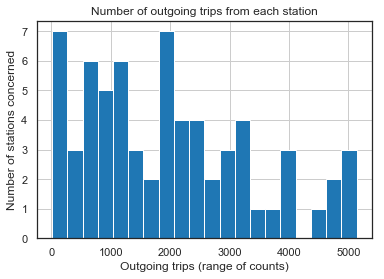

In [43]:
# TASK 1

# Plotting the number of outgoing trips from each station
plt.figure()
# We just count from the principal dataframe the number of reference to each station in the columns
# 'Starting Station ID'
df_metro_bike_share['Starting Station ID'].value_counts().hist(grid=True, bins=20)
plt.title('Number of outgoing trips from each station');
plt.ylabel('Number of stations concerned');
plt.xlabel('Outgoing trips (range of counts)');

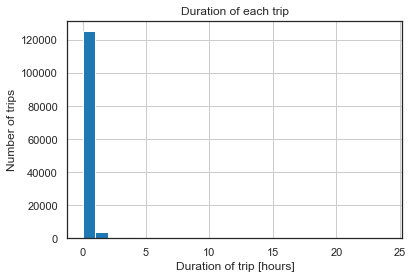

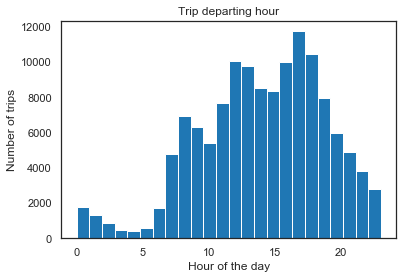

In [48]:
# TASK 2

# Plotting the duration of each trip
max_duration = np.ceil(df_redundant_duration['Duration'].max()/3600).astype(int) # Compute the duration of the longest trip
# to be able to determine the lenght of the graph. NB : the division by 3600 converts the seconds in hours
plt.figure()
(df_redundant_duration['Duration']/3600).hist(grid=True,bins=max_duration)
plt.title('Duration of each trip')
plt.ylabel('Number of trips')
plt.xlabel('Duration of trip [hours]')

# Extract the hour component of the Start Time and just store them in a list
df_start_time = pd.DataFrame(df_metro_bike_share['Start Time'])
list_hour = []
for entry in df_start_time['Start Time']:
    list_hour.append(int(entry[11:13]))

# Plotting Trip departing hour histogram from the list
plt.figure()
plt.hist(list_hour,bins=24)
plt.xlabel('Hour of the day')
plt.ylabel('Number of trips')
plt.title('Trip departing hour')
plt.show()

In [47]:
max_duration = np.ceil(df_redundant_duration['Duration'].max()/3600) # Compute the duration of the longest trip
max_duration

24.0

<Figure size 432x288 with 0 Axes>

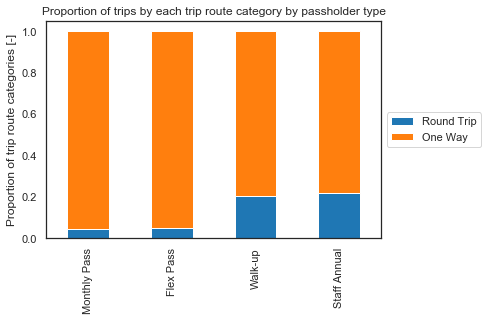

In [19]:
# TASK 3

# First, we will have to rebuild the Data that have previously been removed for cleaning. 
df_passholder_trip_route = pd.merge(df_metro_bike_share,df_redundant_trip_route_cat,left_index = True,left_on = 
                                    'Trip ID', right_on = 'Trip ID')
df_passholder_trip_route = df_passholder_trip_route.drop(columns =['Bike ID', 'Start Time', 'End Time',
                                                                   'Starting Station ID','Ending Station ID','Trip ID'])
df_rt = df_passholder_trip_route[df_passholder_trip_route['Trip Route Category'] == 'Round Trip']
df_ow = df_passholder_trip_route[df_passholder_trip_route['Trip Route Category'] == 'One Way']

# We will store to usage (Round Trip or One Way) in function of the Passholder in a dictionnary
passholderUsage = {
    'Round Trip' : [df_rt[df_rt['Passholder Type']=='Monthly Pass'].count()[0],
                    df_rt[df_rt['Passholder Type']=='Flex Pass'].count()[0],
                    df_rt[df_rt['Passholder Type']=='Walk-up'].count()[0],
                    df_rt[df_rt['Passholder Type']=='Staff Annual'].count()[0]],
    'One Way' : [df_ow[df_ow['Passholder Type']=='Monthly Pass'].count()[0],
                 df_ow[df_ow['Passholder Type']=='Flex Pass'].count()[0],
                 df_ow[df_ow['Passholder Type']=='Walk-up'].count()[0],
                 df_ow[df_ow['Passholder Type']=='Staff Annual'].count()[0]],
}

# Normalisation of datas : subtotal_N_passholder_type_by_trip_route_category / total_N_passholder_type
tripsPerPassholderType = [passholderUsage['Round Trip'][0]+passholderUsage['One Way'][0],
                          passholderUsage['Round Trip'][1]+passholderUsage['One Way'][1],
                          passholderUsage['Round Trip'][2]+passholderUsage['One Way'][2],
                          passholderUsage['Round Trip'][3]+passholderUsage['One Way'][3]]
for array in list(passholderUsage.values()):
    for i in range(len(array)):
        array[i] = array[i]/tripsPerPassholderType[i]

# Converting the dictionary in DataFrame
df_passholder_usage = pd.DataFrame.from_dict(passholderUsage)

# Plotting data
plt.figure()
df_passholder_usage.plot.bar(stacked=True)
plt.title('Proportion of trips by each trip route category by passholder type')
passTypeIndex = ['Monthly Pass','Flex Pass','Walk-up','Staff Annual']
y_pos = np.arange(len(passTypeIndex))
plt.xticks(y_pos, passTypeIndex)
plt.ylabel('Proportion of trip route categories [-]')
plt.legend(loc= 6, bbox_to_anchor=(1, 0.5));
plt.show()


<Figure size 432x288 with 0 Axes>

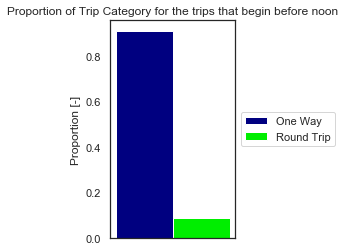

<Figure size 432x288 with 0 Axes>

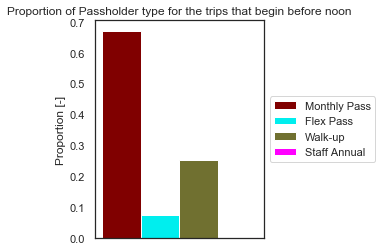

In [20]:
# TASK 4

Trajet_before_noon = df_metro_bike_share[df_metro_bike_share.loc[:, 'Start Time'].\
                                         apply(lambda value: int(value[-8:].split(':')[0]) < 12)]
Before_noon_Passholder_Trip_Cat = pd.merge(Trajet_before_noon, df_redundant_trip_route_cat,\
                                           left_on = 'Trip ID', right_on = 'Trip ID')
Before_noon_Passholder_Trip_Cat = Before_noon_Passholder_Trip_Cat.drop(columns =\
                                ['Bike ID', 'End Time', 'Starting Station ID', 'Ending Station ID', 'Trip ID'])

Total = size(Before_noon_Passholder_Trip_Cat, 0)
Monthly_Pass_num = size(Before_noon_Passholder_Trip_Cat[Before_noon_Passholder_Trip_Cat['Passholder Type'] == 'Monthly Pass'], 0)
Flex_Pass_num = size(Before_noon_Passholder_Trip_Cat[Before_noon_Passholder_Trip_Cat['Passholder Type'] == 'Flex Pass'], 0)
Walk_up_num = size(Before_noon_Passholder_Trip_Cat[Before_noon_Passholder_Trip_Cat['Passholder Type'] == 'Walk-up'], 0)
Staff_Annual_num = size(Before_noon_Passholder_Trip_Cat[Before_noon_Passholder_Trip_Cat['Passholder Type'] == 'Staff Annual'], 0)
One_Way_num = size(Before_noon_Passholder_Trip_Cat[Before_noon_Passholder_Trip_Cat['Trip Route Category'] == 'One Way'], 0)
Round_Trip_num = size(Before_noon_Passholder_Trip_Cat[Before_noon_Passholder_Trip_Cat['Trip Route Category'] == 'Round Trip'], 0)

Propotion_Trip_Cat = {
    'One Way' : One_Way_num/Total,
    'Round Trip' : Round_Trip_num/Total
}

Proportion_Passholder = {
    'Monthly Pass' : Monthly_Pass_num/Total,
    'Flex Pass' : Flex_Pass_num/Total,
    'Walk-up': Walk_up_num/Total,
    'Staff Annual': Staff_Annual_num/Total,
}

df_Trip_cat_noon = pd.DataFrame(Propotion_Trip_Cat, index = [1])
df_Passholder_noon = pd.DataFrame(Proportion_Passholder, index = [1])

plt.figure();
df_Trip_cat_noon.plot.bar(color=['#000080', '#00ee00' ]);
plt.title("Proportion of Trip Category for the trips that begin before noon");
plt.xticks([]);
plt.ylabel("Proportion [-]");
plt.axis("scaled");
plt.legend(loc= 6, bbox_to_anchor=(1, 0.5));
plt.show();

plt.figure();
df_Passholder_noon.plot.bar(color=['#800000', '#00eeee', '#707030', '#ff00ff']);
plt.title("Proportion of Passholder type for the trips that begin before noon");
plt.xticks([]);
plt.ylabel("Proportion [-]");
plt.axis("scaled");
plt.legend(loc= 6, bbox_to_anchor=(1, 0.5));
plt.show();



In [21]:
# TASK 5
df_sorted_hour = pd.merge(df_metro_bike_share, df_redundant_trip_route_cat, left_on = 'Trip ID', right_on = 'Trip ID')
df_sorted_hour = df_sorted_hour.drop(columns = 
                            ['Bike ID', 'End Time', 'Starting Station ID', 'Ending Station ID', 'Trip ID'])
df_sorted_hour.loc[:, ['Start Time']] = df_sorted_hour['Start Time'].apply(lambda x : date.datetime.strptime(x[-8:], "%H:%M:%S"))
df_sorted_hour.loc[:, ['Start Time']] = df_sorted_hour['Start Time'].apply(lambda x : x.time())

hour_ref = date.datetime.strptime("14:58:00", "%H:%M:%S").time()
df_hour_first = df_sorted_hour[df_sorted_hour['Start Time'] < hour_ref].copy()
df_hour_second = df_sorted_hour[df_sorted_hour['Start Time'] >= hour_ref].copy()

index_Pass = ['Monthly Pass', 'Flex Pass', 'Walk-up', 'Staff Annual']
index_Trip = ['One Way', 'Round Trip']
df_hour_first_Trip = df_hour_first.groupby('Start Time')['Trip Route Category'].\
                        value_counts().unstack().fillna(0)[index_Trip].sum()
df_hour_first_Pass = df_hour_first.groupby('Start Time')['Passholder Type'].\
                        value_counts().unstack().fillna(0)[index_Pass].sum()

df_hour_second_Trip = df_hour_second.groupby('Start Time')['Trip Route Category'].\
                        value_counts().unstack().fillna(0)[index_Trip].sum()
df_hour_second_Pass = df_hour_second.groupby('Start Time')['Passholder Type'].\
                        value_counts().unstack().fillna(0)[index_Pass].sum()

Total_hour_first = size(df_hour_first, 0)
Total_hour_second = size(df_hour_second, 0)

Data = {
    "Size sample" : [Total_hour_first, Total_hour_second], 
    "Monthly Pass" : [df_hour_first_Pass["Monthly Pass"]/Total_hour_first, df_hour_second_Pass["Monthly Pass"]/Total_hour_second],
    "Flex Pass" : [df_hour_first_Pass["Flex Pass"]/Total_hour_first, df_hour_second_Pass["Flex Pass"]/Total_hour_second],
    "Walk-up" : [df_hour_first_Pass["Walk-up"]/Total_hour_first, df_hour_second_Pass["Walk-up"]/Total_hour_second],
    "Staff Annual" : [df_hour_first_Pass["Staff Annual"]/Total_hour_first, df_hour_second_Pass["Staff Annual"]/Total_hour_second],
    "One Way" : [df_hour_first_Trip["One Way"]/Total_hour_first, df_hour_second_Trip["One Way"]/Total_hour_second],
    "Round Trip" : [df_hour_first_Trip["Round Trip"]/Total_hour_first, df_hour_second_Trip["Round Trip"]/Total_hour_second]
}

index_data = ["Before 14:58:00", "After 14:58:00 (include)"]

Data_final = pd.DataFrame(Data, index_data)
Data_final

,Size sample,Monthly Pass,Flex Pass,Walk-up,Staff Annual,One Way,Round Trip
Before 14:58:00,66205,0.623306,0.073544,0.299509,0.003640,0.901035,0.098965
After 14:58:00 (include),66222,0.604603,0.070188,0.323080,0.002129,0.905877,0.094123


__ TASK 1 :__

Approach : In this task, we don't need to modify or merge dataframes. We just have to count the number of occurence of each station in the 'Starting Station ID' column of the principal dataframe (df_metro_bike_share) and to plot this result.

__ TASK 2 :__

Approach 1st figure : To realise this figure, we use the dataframe which already contains the durations. We just have to determine the longest duration, in order to determine the length of the x-axis. Then we just have to plot discretize them hour-by-hour and to plot the result.

Approach 2nd figure : Here we just extract the hour component of the Start Time for each entry and store it in a list, which we subsequently plot.

__ What do you observe in each plot? __
In the first plot, we can observe that a huge proportion of the users are only making a one-hour-trip. Therefore, our hour-by-hour representation is not very useful to analyse those data. It would be more interesting to make a zoom plot
on the first 2 hours and to make a 10-minutes-by-10-minutes representation.

__ What are some popular values in the duration plot? __
The most popular hour are located between 8AM and 10PM, with 3 little "hills" during the morning, after midday and at
the end of the afternoon, which could correspond to the communting.

__ TASK 3 :__

Approach : In this task, we first have to recombine our dataframes in order to obtain parallely the columns 'Trip Route Category' and 'Passholder Type'. Then we divide the data in function of the 2 trip route categories and in function of the 4 passholder types. We subsequently normalize the data in regard to the total number of entry in each passholder types and we plot the data.
